In [5]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
np.random.seed(42)
tf.set_random_seed(42)
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
import seaborn as sns
from numpy import float32,int32
from numpy import mean
from numpy import std
from numpy import dstack
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, Flatten, Dropout, Permute, Reshape
from keras.layers import LSTM, Embedding, Flatten, RepeatVector, TimeDistributed, Concatenate
from keras.callbacks import TensorBoard, ModelCheckpoint
import os
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd


%matplotlib inline
matplotlib.style.use('ggplot')
DATADIR = 'HARDataset'

SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}


# Utility function to read the data from csv file                     
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []
    for signal in SIGNALS:
        filename = '{0}/{1}/Inertial Signals/{2}_{3}.txt'.format(DATADIR,subset,signal,subset)
        signals_data.append(
            _read_csv(filename).as_matrix()
        )
    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    '''>>> x = np.ones((1, 2, 3))
       >>> np.transpose(x, (1, 0, 2)).shape
       (2, 1, 3)'''
    return np.transpose(signals_data, (1, 2, 0))

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = '{0}/{1}/y_{2}.txt'.format(DATADIR,subset,subset)
    y = _read_csv(filename)[0]
    return pd.get_dummies(y).as_matrix()
"""
>>> s = pd.Series(list('abca'))
>>> pd.get_dummies(s)
   a  b  c
0  1  0  0
1  0  1  0
2  0  0  1
3  1  0  0"""

def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
 shape:   
[samples, time steps, features]
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')
    print(X_train.shape)
    return X_train, X_test, y_train, y_test

LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
lables=np.array(LABELS)

def one_hot(y_):
    """
    Function to encode output labels from number indexes.
    E.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    """
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

def _count_classes(y):
    return len(set([tuple(category) for category in y]))

def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [17]:
# run an experiment
X_train, X_test, Y_train, Y_test = load_data()
y_test=Y_test.argmax(1)
n_timesteps,n_features,n_outputs=X_train.shape[1],X_train.shape[2],Y_train.shape[1]
n_steps, n_length=2,64
X_train=X_train.reshape((X_train.shape[0],n_steps,n_length,n_features))
X_test=X_test.reshape((X_test.shape[0],n_steps,n_length,n_features))
verbose, epochs, batch_size, validation_split = 1, 30, 32, 0.2
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=10, activation='relu'),input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=10, activation='relu')))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=10, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(Bidirectional(LSTM(256)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
#model.add(Dense(n_outputs, activation='softmax'))
model.add(Dense(6, activation='softmax'))
model.summary()
adam=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# fit network
history=model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_split=validation_split,shuffle=True)

C:\Users\User\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\User\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:89: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


(7352, 128, 9)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_36 (TimeDis (None, None, 55, 64)      5824      
_________________________________________________________________
time_distributed_37 (TimeDis (None, None, 46, 64)      41024     
_________________________________________________________________
time_distributed_38 (TimeDis (None, None, 37, 64)      41024     
_________________________________________________________________
time_distributed_39 (TimeDis (None, None, 18, 64)      0         
_________________________________________________________________
time_distributed_40 (TimeDis (None, None, 1152)        0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 512)               2885632   
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0     

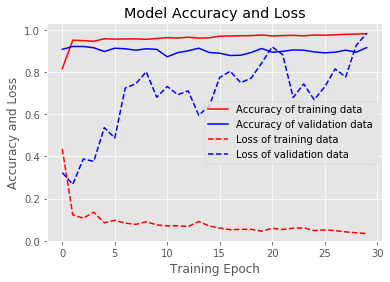

In [21]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

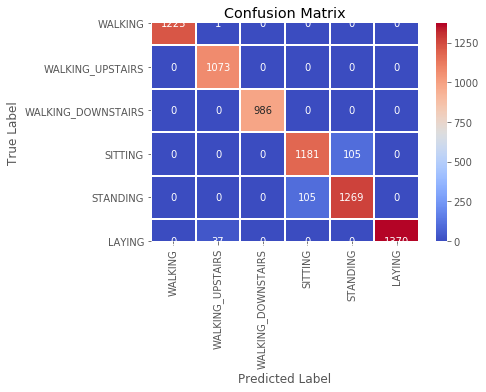

[[1225    1    0    0    0    0]
 [   0 1073    0    0    0    0]
 [   0    0  986    0    0    0]
 [   0    0    0 1181  105    0]
 [   0    0    0  105 1269    0]
 [   0   37    0    0    0 1370]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1226
           1       0.97      1.00      0.98      1073
           2       1.00      1.00      1.00       986
           3       0.92      0.92      0.92      1286
           4       0.92      0.92      0.92      1374
           5       1.00      0.97      0.99      1407

    accuracy                           0.97      7352
   macro avg       0.97      0.97      0.97      7352
weighted avg       0.97      0.97      0.97      7352



In [22]:
# Print confusion matrix for training data
y_pred_train = model.predict(X_train)
max_y_pred_train = np.argmax(y_pred_train, axis=1)
max_y_train = np.argmax(Y_train,axis=1)
show_confusion_matrix(max_y_train, max_y_pred_train)
cm= metrics.confusion_matrix(max_y_train, max_y_pred_train)
print(cm)
print(classification_report(max_y_train, max_y_pred_train))

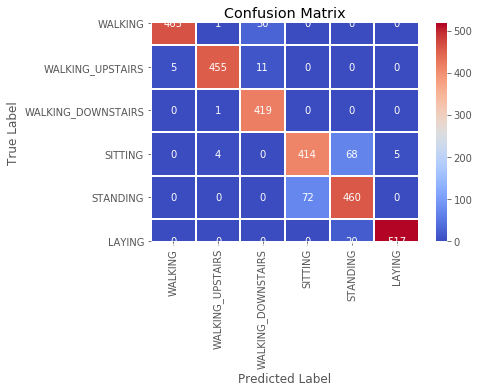

[[465   1  30   0   0   0]
 [  5 455  11   0   0   0]
 [  0   1 419   0   0   0]
 [  0   4   0 414  68   5]
 [  0   0   0  72 460   0]
 [  0   0   0   0  20 517]]
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       496
           1       0.99      0.97      0.98       471
           2       0.91      1.00      0.95       420
           3       0.85      0.84      0.85       491
           4       0.84      0.86      0.85       532
           5       0.99      0.96      0.98       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947

2947/2947 [==============================] - 4s 1ms/step
0.9263658012258105


In [23]:
# Print confusion matrix for test data
y_pred_test=model.predict(X_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(Y_test, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
cm= metrics.confusion_matrix(max_y_test, max_y_pred_test)
print(cm)
print(classification_report(max_y_test, max_y_pred_test))
#print("predict#################",predict)
_, accuracy = model.evaluate(X_test, Y_test, batch_size=200, verbose=1)
print(accuracy)

In [24]:
model2 = Model(inputs=model.inputs, outputs=model.layers[-3].output)
lstm_output_train= model2.predict(X_train)
print('lstm_output_train: ',lstm_output_train)
lstm_output_test = model2.predict(X_test)
print('lstm_output_test: ',lstm_output_test)

lstm_output_train:  [[ 0.0000000e+00  6.2158996e-01 -2.8833166e-01 ...  2.5932267e-01
  -1.6351998e-01 -4.4925988e-01]
 [-2.1089015e-04  6.1568558e-01 -2.9123291e-01 ...  2.3049408e-01
  -1.4712809e-01 -4.3952644e-01]
 [-2.2059679e-04  6.0769451e-01 -2.8449425e-01 ...  2.3784047e-01
  -1.3572763e-01 -4.4524342e-01]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
lstm_output_test:  [[ 0.          0.4722736  -0.07896368 ...  0.35410973 -0.4334339
  -0.40627542]
 [ 0.          0.507917   -0.09181473 ...  0.35246888 -0.41113403
  -0.4133191 ]
 [ 0.          0.50466603 -0.093509   ...  0.33858326 -0.38232175
  -0.42852083]
 ...
 [ 0.          0.          0.         ...  0.15545745  0.
   0.        ]
 [ 0.          0.          0.         ...

In [25]:
np.savetxt('uci_lstm_output_train.csv',lstm_output_train, delimiter=',', fmt='%.7e')
np.savetxt('uci_lstm_output_test.csv',lstm_output_test, delimiter=',', fmt='%.7e')

In [26]:
df_lstm_test=pd.DataFrame(lstm_output_test)
df_lstm_train=pd.DataFrame(lstm_output_train)

from sklearn.preprocessing import normalize
normalized_df_lstm_test=pd.DataFrame(normalize(df_lstm_test))
normalized_df_lstm_train=pd.DataFrame(normalize(df_lstm_train))

In [27]:
Y_train

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]], dtype=uint8)

In [28]:
y_train_hot=np.argmax(Y_train,axis=1)
y_train_hot
y_test_hot=np.argmax(Y_test,axis=1)
y_test_hot

array([4, 4, 4, ..., 1, 1, 1], dtype=int64)

In [29]:
result_train2=[]
for i in y_train_hot:
    if i == 0:
        result_train2.append('WALKING')
    if i == 1:
        result_train2.append('WALKING_UPSTAIRS')
    if i == 2:
        result_train2.append('WALKING_DOWNSTAIRS')
    if i == 3:
        result_train2.append('SITTING')
    if i == 4:
        result_train2.append('STANDING')
    if i == 5:
        result_train2.append('LAYING')

print(result_train2)

['STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'WALKING', 'WALKING', 'WALKING', 'WALKING', 'WALKING', 'WALKING', 'WALKING', 'WALKING', 'WALKING', 'WALKING', 'WALKING', 'WALKING', 'WALKING'

In [30]:
result_test2=[]
for i in y_test_hot:
    if i == 0:
        result_test2.append('WALKING')
    if i == 1:
        result_test2.append('WALKING_UPSTAIRS')
    if i == 2:
        result_test2.append('WALKING_DOWNSTAIRS')
    if i == 3:
        result_test2.append('SITTING')
    if i == 4:
        result_test2.append('STANDING')
    if i == 5:
        result_test2.append('LAYING')
print(result_test2)

['STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'WALKING', 'WALKING', 'WALKING', 'WALKING', 'WALKING', 'WALKING', 'WALKING', 'WALKING', 'WALKING', 'WALKING', 'WALKING', 'W

In [31]:
df_train2=pd.DataFrame(result_train2)
df_test2=pd.DataFrame(result_test2)

In [32]:
merged_lstm_test_file2=pd.concat([normalized_df_lstm_test,df_test2],axis=1)
merged_lstm_train_file2=pd.concat([normalized_df_lstm_train,df_train2],axis=1)

In [33]:
merged_lstm_test_file2

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,0
0,0.000000,0.042465,-0.007100,0.085802,0.030936,0.083905,-0.006135,-0.081246,-0.000306,-0.086676,...,-0.000000,0.016703,0.000000,-0.002439,0.086510,0.000000,0.031840,-0.038972,-0.036530,STANDING
1,0.000000,0.046192,-0.008350,0.086547,0.031125,0.084120,-0.007760,-0.081766,-0.000957,-0.087666,...,-0.000000,0.018666,0.000000,-0.003675,0.087430,0.000000,0.032055,-0.037390,-0.037589,STANDING
2,0.000000,0.045973,-0.008518,0.086669,0.031070,0.083963,-0.007478,-0.081837,-0.000698,-0.087811,...,-0.000000,0.018801,0.000000,-0.002793,0.087583,0.000000,0.030844,-0.034828,-0.039037,STANDING
3,0.000000,0.047188,-0.007023,0.086359,0.030985,0.084078,-0.007330,-0.081611,-0.000340,-0.086962,...,-0.000000,0.018474,0.000000,-0.002319,0.086776,0.000000,0.031004,-0.036173,-0.038443,STANDING
4,0.000000,0.047909,-0.007663,0.085749,0.030031,0.084437,-0.006897,-0.080555,-0.000092,-0.086020,...,-0.000000,0.018824,0.000000,-0.001027,0.085857,0.000000,0.028305,-0.037160,-0.039576,STANDING
5,0.000000,0.048983,-0.007526,0.085141,0.030118,0.084242,-0.006285,-0.079608,-0.000000,-0.085323,...,-0.000000,0.018134,0.000000,-0.000219,0.085179,0.000000,0.028292,-0.039266,-0.040288,STANDING
6,0.000000,0.048153,-0.007077,0.085128,0.030214,0.084208,-0.006106,-0.079939,-0.000000,-0.085308,...,-0.000000,0.018028,0.000000,-0.000395,0.085170,0.000000,0.028392,-0.039515,-0.040028,STANDING
7,0.000000,0.048259,-0.007296,0.085093,0.029843,0.084175,-0.006133,-0.079803,-0.000000,-0.085273,...,-0.000000,0.018209,0.000000,-0.000368,0.085135,0.000000,0.028662,-0.039575,-0.039970,STANDING
8,0.000000,0.048645,-0.007425,0.084992,0.030103,0.084138,-0.006009,-0.079424,-0.000000,-0.085166,...,-0.000000,0.018148,0.000000,-0.000205,0.085029,0.000000,0.028504,-0.039437,-0.040297,STANDING
9,0.000000,0.048312,-0.007191,0.085091,0.030268,0.084225,-0.006148,-0.079617,-0.000000,-0.085257,...,-0.000000,0.018049,0.000000,-0.000291,0.085119,0.000000,0.028538,-0.039719,-0.040192,STANDING


In [34]:
np.savetxt('uci_merged_lstm_test_file2.csv',merged_lstm_test_file2, delimiter=',',fmt='%s')
np.savetxt('uci_merged_lstm_train_file2.csv',merged_lstm_train_file2, delimiter=',',fmt='%s')